In [1]:
import itertools
import numpy as np 
import sys
sys.path.append('../')
from SetupTransitionTable import SetupDeterministicTransitionByStateSet
from SetupRewardTable import SetupStateActionRewardWithUserSpecifiedCosts
from visualizations import *
from ValueIteration import *

# Setup Belief Dynamics

In [2]:
class SetupBeliefTransition(object):
    def __init__(self, positionSet, beliefSet, actionSet):
        self.positionSet = positionSet
        self.beliefSet = beliefSet
        self.actionSet = actionSet

    def __call__(self, getNewBelief):
        beliefTransition = {(position, belief): self.getActionNewBeliefTransition(position, belief, getNewBelief) \
         for position in self.positionSet \
         for belief in self.beliefSet}
        return(beliefTransition)
    
    def getActionNewBeliefTransition(self, position, belief, getNewBelief):
        actionTransition = {}
        for action in self.actionSet:
            newPosition = self.updatePosition(position, action)
            newBeliefDictionary = getNewBelief(newPosition, belief)
            actionTransition[action] = newBeliefDictionary
        return(actionTransition)
        
    def updatePosition(self, position, action):
        potentialNextState = tuple([position[i] + action[i] for i in range(len(position))])
        if potentialNextState in self.positionSet:
            return(potentialNextState)
        return(position) 

In [3]:
def updateBelief(newPosition, belief):
    positionsTruck1Visible = [(0, 0),(1, 3),(3, 0),(0, 2),(2, 1),(1, 0),(0, 3),(4, 0),(0, 1),(1, 2),(3, 1),(2, 0),(4, 1),(1, 1)]
    positionsTruck2Visible = [(0,3), (1,3), (2,3), (3,3), (4,3)] 
    truck1Observed, truck2Observed = [1 if newPosition in truckPositions else 0 for truckPositions in [positionsTruck1Visible,positionsTruck2Visible]]
    
    if truck1Observed and truck2Observed:
        possibleObservations = [("K", "L"), ("K", "M"), ("L", "K"), ("L", "M"), ("M", "K"),("M", "L")]
    elif truck1Observed and not truck2Observed:
        possibleObservations = [("K",""), ("L", ""), ("M", "")]
    elif truck2Observed and not truck1Observed:
        possibleObservations = [("", "K"), ("", "L"), ("", "M")]
    else:
        possibleObservations = [("", "")]
        
    unNormalizedBeliefs = [createBelief(belief, observation) for observation in possibleObservations if compatible(observation,belief)]
    normalizedBeliefs = [tuple([float(i)/sum(belief) for i in belief]) for belief in unNormalizedBeliefs]
    
    nextBeliefs = {(newPosition, belief): 1/len(normalizedBeliefs) for belief in normalizedBeliefs}
    return(nextBeliefs)

In [4]:
def createBelief(belief, truckObservation):
    beliefTruck = convertBeliefToTruck(belief)
    newTruck = addTrucks(beliefTruck, truckObservation)
    return(convertTruckToBelief(newTruck))

def addTrucks(trucks1,trucks2):
    newTruck = list(trucks1)
    for i in range(len(trucks1)):
        if trucks1[i] != "" and trucks2[i] != "":
            assert trucks1[i] == trucks2[i], "Error! observation is inconsistent with belief!!!"
    for i in range(len(trucks1)):
        if trucks1[i] == "" and trucks2[i] != "":
            newTruck[i] = trucks2[i]
    return tuple(newTruck)

def compatible(observation, belief):
    beliefTruck = convertBeliefToTruck(belief)
    for i in range(len(beliefTruck)):
        if beliefTruck[i] != "" and observation[i] != "":
            if beliefTruck[i] != observation[i]:
                return False
    if beliefTruck[0] == observation[1] and beliefTruck[0] != "": return False
    if beliefTruck[1] == observation[0] and beliefTruck[1] != "": return False
    return True

def convertTruckToBelief(truck):
    truckNames = ["K", "L", "M"]
    beliefArray = np.array([[0, 0, 0], [0, 0, 0],[0, 0, 0]])
    belief = [0,0,0,0,0,0]
    
    for i in range(len(truckNames)):
        if truck[0] == truckNames[i]: beliefArray[i,:] = 1
        if truck[1] == truckNames[i]: beliefArray[:,i] = 1
        beliefArray[i,i]=0 

    rowSums = np.sum(beliefArray, axis = 1)
    colSums = np.sum(beliefArray, axis = 0)
    beliefArraySum = np.array([[          0          , rowSums[0]+colSums[1], rowSums[0]+colSums[2]],
                               [rowSums[1]+colSums[0],           0          , rowSums[1]+colSums[2]],
                               [rowSums[2]+colSums[0], rowSums[2]+colSums[1],           0          ]])
    maxBelief = np.max(beliefArraySum)
    
    world = 0
    for i in range(beliefArraySum.shape[0]):
        for j in range(beliefArraySum.shape[1]):
            if i==j: continue
            if beliefArraySum[i,j] == maxBelief:
                belief[world] = 1
            world = world+1
    belief = [b/sum(belief) for b in belief]
    
    return(tuple([round(x,2) for x in belief]))

def convertBeliefToTruck(belief):
    truckNames = ["K", "L", "M"]
    beliefArray = np.array([[0, belief[0], belief[1]], [belief[2], 0, belief[3]],[belief[4], belief[5], 0]])
    
    beliefTruck = ["", ""]
    rowSums = np.sum(beliefArray, axis = 1)
    colSums = np.sum(beliefArray, axis = 0)
    if np.argwhere(rowSums == 1).size ==1:
        beliefTruck[0] = truckNames[int(np.argwhere(rowSums == 1))]
    if np.argwhere(colSums == 1).size ==1:
        beliefTruck[1] = truckNames[int(np.argwhere(colSums == 1))]
    return(tuple(beliefTruck))


In [5]:
class SetupRewardBeliefTable(object):
    def __init__(self, positionSet, beliefSet, actionSet):
        self.positionSet = positionSet
        self.beliefSet = beliefSet
        self.actionSet = actionSet
        
    def __call__(self, beliefTransition, worldRewardList):
        rewardTable = {(position, belief): {action: {nextState: self.getRewardBelief(position, belief, action, worldRewardList) \
                                                         for nextState in beliefTransition[(position, belief)][action].keys()}\
                             for action in self.actionSet} \
         for position in self.positionSet \
         for belief in self.beliefSet}
        return(rewardTable)
    
    def getRewardBelief(self, position, belief, action, worldRewards):
        #print("Belief Reward Called", [reward for reward, probWorld in zip(worldRewards, belief)])
        rewardBelief = sum([reward[position][action]*probWorld for reward, probWorld in zip(worldRewards, belief)])
        return(rewardBelief)


# Environment Setup

In [6]:
# Actions correspond to E, N, W, S, Stay respectively
allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]

#all location states in grid
gridWidth = 5
gridHeight = 4
gridSet = set(itertools.product(range(gridWidth), range(gridHeight)))

#set of states to remove from each environment
barriersC = {(2,2), (3,2), (4,2)}

#final environment state sets
stateSetC = list(gridSet.difference(barriersC))

#goal locations
goalTruck1 = (0,0)
goalTruck2 = (4,3)

#observation positions
observeTruck1 = [(0, 0),(1, 3),(3, 0),(0, 2),(2, 1),(1, 0),(0, 3),(4, 0),(0, 1),(1, 2),(3, 1),(2, 0),(4, 1),(1, 1)]
observeTruck2 = [(0,3), (1,3), (2,3), (3,3), (4,3)] 

#possible beliefs
beliefSet= list(set([t for t in itertools.permutations([1,0,0,0,0,0], 6)]))
otherHypotheses = [(.5,.5,0,0,0,0),(0,0,.5,.5,0,0),(0,0,0,0,.5,.5),(0,0,.5,0,0.5,0),(.5,0,0,0,0,0.5),(0,.5,0,.5,0,0),(.17,.17,.17,.17,.17,.17)]
beliefSet.extend(otherHypotheses)

# Example

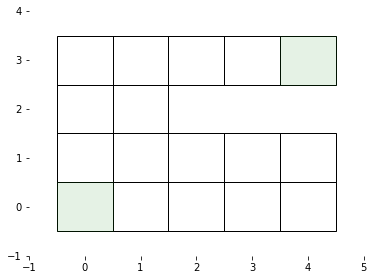

In [7]:
visualizeEnvironmentByState(states = stateSetC, goalStates = [goalTruck1, goalTruck2])

In [8]:
getTransition = SetupDeterministicTransitionByStateSet(stateSetC, allActions)
positionTransition = getTransition()

## Belief Transition Setup

In [9]:
getTransitionC = SetupBeliefTransition(stateSetC, beliefSet, allActions)
beliefTransition_EnvC = getTransitionC(updateBelief)

In [10]:
[''.join(preference) for preference in itertools.permutations("KLM",3)]

['KLM', 'KML', 'LKM', 'LMK', 'MKL', 'MLK']

In [11]:
viewDictionaryStructure(beliefTransition_EnvC, 't')

state: ((0, 0), (0, 0, 0, 0, 1, 0))
	action: (1, 0)
		next state: ((1, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, 1)
		next state: ((0, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (-1, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, -1)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
	action: (0, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			probability: 1.0
state: ((0, 0), (1, 0, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (0, 1)
		next state: ((0, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (-1, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (0, -1)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
	action: (0, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			probability: 1.0
state: ((0, 0)

	action: (0, -1)
		next state: ((3, 0), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			probability: 0.5
		next state: ((3, 0), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			probability: 0.5
	action: (0, 0)
		next state: ((3, 1), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			probability: 0.5
		next state: ((3, 1), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			probability: 0.5
state: ((3, 1), (0.17, 0.17, 0.17, 0.17, 0.17, 0.17))
	action: (1, 0)
		next state: ((4, 1), (0.5, 0.5, 0.0, 0.0, 0.0, 0.0))
			probability: 0.3333333333333333
		next state: ((4, 1), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0))
			probability: 0.3333333333333333
		next state: ((4, 1), (0.0, 0.0, 0.0, 0.0, 0.5, 0.5))
			probability: 0.3333333333333333
	action: (0, 1)
		next state: ((3, 1), (0.5, 0.5, 0.0, 0.0, 0.0, 0.0))
			probability: 0.3333333333333333
		next state: ((3, 1), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0))
			probability: 0.3333333333333333
		next state: ((3, 1), (0.0, 0.0, 0.0, 0.0, 0.5, 0.5))
			probability: 0.3333333333333333
	action: (-1, 0)
		next state: ((2, 1), (

### Example transitions

In [12]:
st = ((0,2), beliefSet[6])
a = (0,1)
print(st, "\n", beliefTransition_EnvC[st][a])

((0, 2), (0.5, 0.5, 0, 0, 0, 0)) 
 {((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0)): 0.5, ((0, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0)): 0.5}


## List of Rewards for Possible Worlds

In [13]:
allWorlds = ['KL', 'KM', 'LK', 'LM', 'MK', 'ML']
allPreferences = [''.join(preference) for preference in itertools.permutations("KLM",3)]

In [14]:
def constructGoalStateRewards(truck1truck2,  preference, truckLocations = [(0,0), (4,3)], preferenceRewards = [100, 75, 50]):
    goalPreferences = {location : preferenceRewards[preference.index(truck)] for location, truck in zip(truckLocations, truck1truck2)}
    return(goalPreferences)

In [15]:
getRewardC = SetupStateActionRewardWithUserSpecifiedCosts(positionTransition, allActions, [goalTruck1,goalTruck2])
rewards_EnvC_PrefMLK = [getRewardC(constructGoalStateRewards(world, 'MLK')) for world in allWorlds]

In [16]:
getRewardBeliefs = SetupRewardBeliefTable(stateSetC, beliefSet, allActions)
beliefReward_EnvC_MLK = getRewardBeliefs(beliefTransition_EnvC, rewards_EnvC_PrefMLK)

### Example Rewards

In [17]:
viewDictionaryStructure(beliefReward_EnvC_MLK, 'r')

state: ((0, 0), (0, 0, 0, 0, 1, 0))
	action: (1, 0)
		next state: ((1, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 99
	action: (0, 1)
		next state: ((0, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 99
	action: (-1, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 99
	action: (0, -1)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 99
	action: (0, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 99.9
state: ((0, 0), (1, 0, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: 49
	action: (0, 1)
		next state: ((0, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: 49
	action: (-1, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: 49
	action: (0, -1)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: 49
	action: (0, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: 49.9
state: ((0, 0), (0, 0, 1, 0, 0, 0))
	action: (1, 0)
		next state: ((1,

			reward: -1
	action: (0, 1)
		next state: ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (-1, 0)
		next state: ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, -1)
		next state: ((0, 2), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, 0)
		next state: ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -0.1
state: ((0, 3), (0, 0, 1, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, 1)
		next state: ((0, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (-1, 0)
		next state: ((0, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, -1)
		next state: ((0, 2), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, 0)
		next state: ((0, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -0.1
state: ((0, 3), (0, 1, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, 1)
		next state: ((0, 3), (0.0, 1.0, 0.0, 0

		next state: ((3, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -0.1
state: ((3, 1), (0.5, 0, 0, 0, 0, 0.5))
	action: (1, 0)
		next state: ((4, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((4, 1), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (0, 1)
		next state: ((3, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((3, 1), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((2, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((2, 1), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (0, -1)
		next state: ((3, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((3, 0), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (0, 0)
		next state: ((3, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -0.1
		next state: ((3, 1), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -0.1
state: ((3, 1), (0, 0.5, 0, 0.5, 0, 0))
	action: (1, 0)
		next state: ((4, 1), (0.0, 1.0, 0.0, 0.

		next state: ((4, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: 61.5
	action: (0, 1)
		next state: ((4, 3), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 61.5
		next state: ((4, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: 61.5
	action: (-1, 0)
		next state: ((3, 3), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 61.5
		next state: ((3, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: 61.5
	action: (0, -1)
		next state: ((4, 3), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 61.5
		next state: ((4, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: 61.5
	action: (0, 0)
		next state: ((4, 3), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: 62.400000000000006
		next state: ((4, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: 62.400000000000006
state: ((4, 3), (0, 0, 0.5, 0, 0.5, 0))
	action: (1, 0)
		next state: ((4, 3), (0.0, 0.0, 0.5, 0.0, 0.5, 0.0))
			reward: 49.0
	action: (0, 1)
		next state: ((4, 3), (0.0, 0.0, 0.5, 0.0, 0.5, 0.0))
			reward: 49.0
	action: (-1, 0)
		next state: ((3, 3), (0.0, 0.0, 0.

In [18]:
worldIndex = 0
state = (4,3)
action= (1,0)
print("world: ", allWorlds[worldIndex], "\n state: ", state, "\n", "reward:", rewards_EnvC_PrefMLK[worldIndex][state][action])

world:  KL 
 state:  (4, 3) 
 reward: 74


## Value Iteration

In [19]:
valueTable = {state:0 for state in beliefTransition_EnvC.keys()}
getPolicy_EnvC_MLK = BoltzmannValueIteration(beliefTransition_EnvC, beliefReward_EnvC_MLK, valueTable, 10e-7, .99, .8)
#getPolicy_EnvC_MLK = DeterministicValueIteration(beliefTransition_EnvC, beliefReward_EnvC_MLK, valueTable, 10e-7, .99)
optimalValuesA, policy_EnvC_MLK = getPolicy_EnvC_MLK()

scaling exponents to [0,700]... On State:
((0, 0), (0, 0, 0, 0, 1, 0))
scaling exponents to [0,700]... On State:
((0, 0), (1, 0, 0, 0, 0, 0))
scaling exponents to [0,700]... On State:
((0, 0), (0, 0, 1, 0, 0, 0))
scaling exponents to [0,700]... On State:
((0, 0), (0, 1, 0, 0, 0, 0))
scaling exponents to [0,700]... On State:
((0, 0), (0, 0, 0, 1, 0, 0))
scaling exponents to [0,700]... On State:
((0, 0), (0, 0, 0, 0, 0, 1))
scaling exponents to [0,700]... On State:
((0, 0), (0.5, 0.5, 0, 0, 0, 0))
scaling exponents to [0,700]... On State:
((0, 0), (0, 0, 0.5, 0.5, 0, 0))
scaling exponents to [0,700]... On State:
((0, 0), (0, 0, 0, 0, 0.5, 0.5))
scaling exponents to [0,700]... On State:
((0, 0), (0, 0, 0.5, 0, 0.5, 0))
scaling exponents to [0,700]... On State:
((0, 0), (0.5, 0, 0, 0, 0, 0.5))
scaling exponents to [0,700]... On State:
((0, 0), (0, 0.5, 0, 0.5, 0, 0))
scaling exponents to [0,700]... On State:
((0, 0), (0.17, 0.17, 0.17, 0.17, 0.17, 0.17))
scaling exponents to [0,700]... On 

In [20]:
#preference MLK
allWorlds

['KL', 'KM', 'LK', 'LM', 'MK', 'ML']

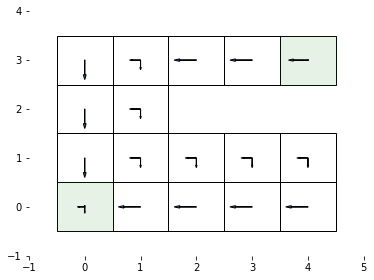

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0, 0, 1, 0] None


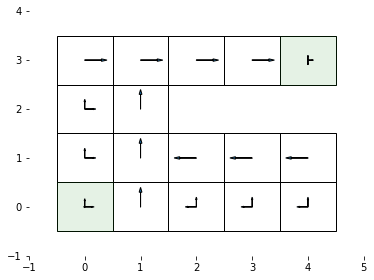

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [1, 0, 0, 0, 0, 0] None


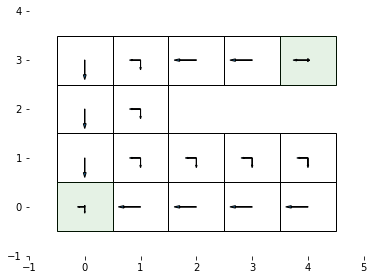

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 1, 0, 0, 0] None


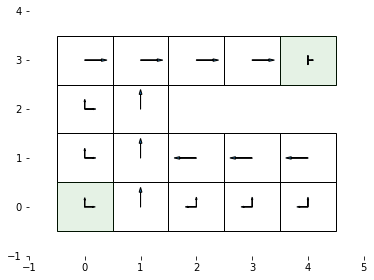

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 1, 0, 0, 0, 0] None


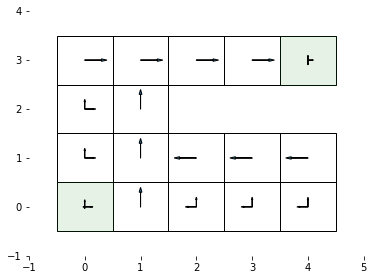

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0, 1, 0, 0] None


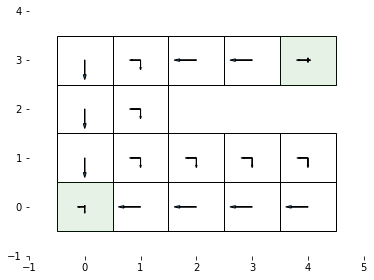

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0, 0, 0, 1] None


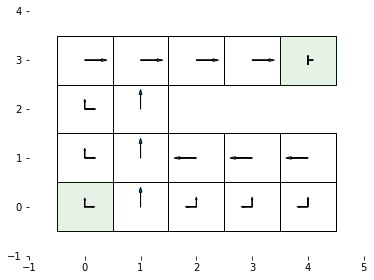

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0.5, 0.5, 0, 0, 0, 0] None


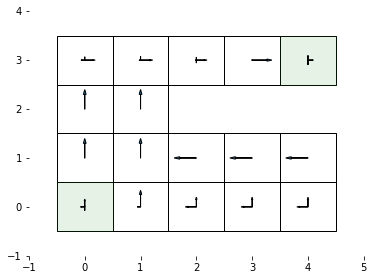

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0.5, 0.5, 0, 0] None


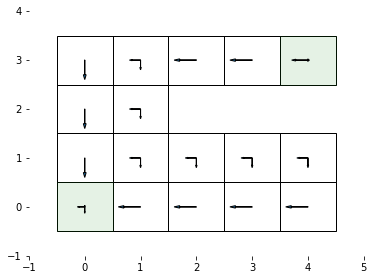

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0, 0, 0.5, 0.5] None


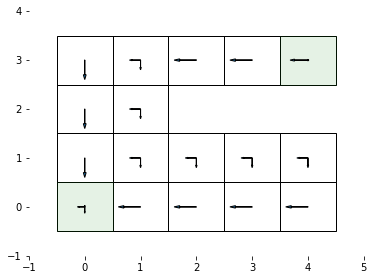

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0, 0.5, 0, 0.5, 0] None


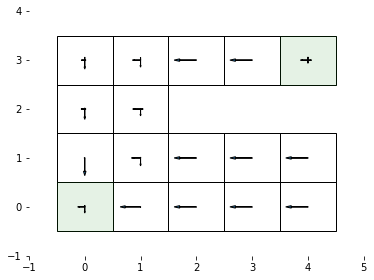

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0.5, 0, 0, 0, 0, 0.5] None


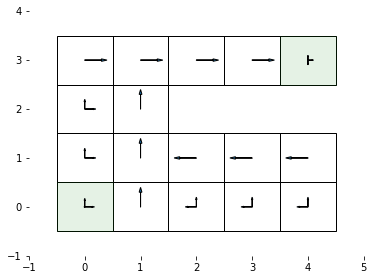

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0, 0.5, 0, 0.5, 0, 0] None


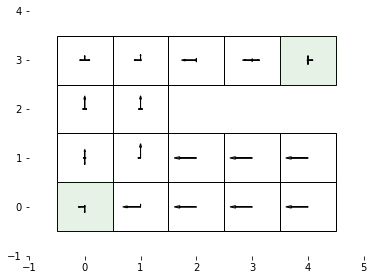

['KL', 'KM', 'LK', 'LM', 'MK', 'ML'] 
 [0.17, 0.17, 0.17, 0.17, 0.17, 0.17] None


[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [21]:
[print(allWorlds,"\n",list(b), visualizePolicyOfBeliefByState(stateSetC, policy_EnvC_MLK, b, goalStates = [goalTruck1, goalTruck2])) for b in beliefSet]

In [22]:
def samplePathToGoal(position, belief, policy, transition, goals):
    trajectory = [(position, belief)]

    while position not in goals:
        #take action probabilisitically
        actions = list(policy[(position, belief)].keys())
        probOfAction = [policy[(position, belief)][action] for action in actions]
        actionIndex = np.random.choice(len(actions), 1, p = probOfAction)
        sampledAction = actions[int(actionIndex)]
        
        #get new position and belief
        newPosition = list(transition[(position, belief)][sampledAction].keys())[0][0]
        possibleBeliefs = list(transition[(position, belief)][sampledAction].keys())
        sampledNewBeliefIndex = int(np.random.choice(len(possibleBeliefs), 1))
        
        #update to new belief/position and add to trajectory
        belief = possibleBeliefs[sampledNewBeliefIndex][1]
        position = newPosition
        trajectory.append((position, belief))
    return(trajectory)

In [29]:
#np.random.seed(127)
path = samplePathToGoal((1,3), (.17,.17,.17,.17,.17,.17), policy_EnvC_MLK, beliefTransition_EnvC, [(0,0), (4,3)])
positionTrajectory = [pos for pos, belief in path]

world = convertBeliefToTruck(path[-1][1])
worldNames = {(0,0): world[0], (4,3):world[1]}

In [30]:
path

[((1, 3), (0.17, 0.17, 0.17, 0.17, 0.17, 0.17)),
 ((2, 3), (0.0, 0.5, 0.0, 0.5, 0.0, 0.0)),
 ((3, 3), (0.0, 0.5, 0.0, 0.5, 0.0, 0.0)),
 ((4, 3), (0.0, 0.5, 0.0, 0.5, 0.0, 0.0))]

In [25]:
positionTrajectory

[(1, 3), (0, 3), (0, 2), (0, 1), (0, 0)]

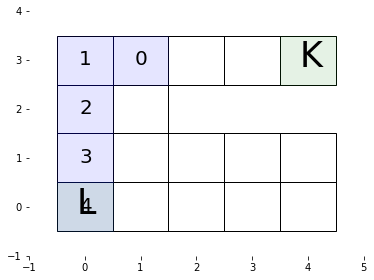

In [26]:
visualizeEnvironmentByState(states = stateSetC, goalStates = [(0,0), (4,3)], trajectory = positionTrajectory, goalNameDictionary=worldNames)

# Inference Step

In [27]:
def inferBelief(positionTrajectory, world, initialBelief = (.17,.17,.17,.17,.17,.17)):
    positionsTruck1Visible = [(0, 0),(1, 3),(3, 0),(0, 2),(2, 1),(1, 0),(0, 3),(4, 0),(0, 1),(1, 2),(3, 1),(2, 0),(4, 1),(1, 1)]
    positionsTruck2Visible = [(0,3), (1,3), (2,3), (3,3), (4,3)] 
    
    stateTrajectory = [(positionTrajectory[0], initialBelief)]
    beliefAtTimeT = initialBelief
    for position in positionTrajectory[1:]:
        observation = ["", ""]
        if position in positionsTruck1Visible:
            observation[0] = world[0] 
        if position in positionsTruck2Visible:
            observation[1] = world[1]
        beliefAtTimeT = createBelief(beliefAtTimeT, tuple(observation))   
        stateTrajectory.append((position, beliefAtTimeT))
    return(stateTrajectory)

In [28]:
class PerformDesireInference(object):
    def __init__(self, transitionTable, desirePolicies, desirePriors, stateTrajectory):
        self.transitionTable = transitionTable
        self.desirePolicies  = desirePolicies
        self.desirePriors = desirePriors
        self.stateTrajectory = stateTrajectory

    def __call__(self):
        posterior = self.getSequenceOfBeliefProbabilities()*np.array(self.desirePriors)        
        row_sums = posterior.sum(axis=1, keepdims=True)
        normalizedPosterior = posterior / row_sums
        return(normalizedPosterior)
        
    def getNextStateProbability(self, state, nextState, policy):
        possibleActionsToNextState = [action for action in self.transitionTable[state] \
                                      if nextState in self.transitionTable[state][action]]

        probNextState = sum([self.transitionTable[state][action][nextState]*policy[state][action] \
                             for action in possibleActionsToNextState])
        return(probNextState)
    
    def getSequenceOfStateProbabilities(self):
        probNextState = [self.desirePriors]
        for t, state in enumerate(self.stateTrajectory[:-1]):
            nextState = self.stateTrajectory[t+1]
            probNextState.append([self.getNextStateProbability(state, nextState, goalPolicy) \
                         for desirePolicies in self.desirePolicies])
        observedStateProbs = np.cumprod(np.array(probNextState), axis=0)
        return(observedStateProbs)